# Bike Rental Demand Forecasting Using Time Series Analysis



# Problem Statement:
A bike-sharing company wants to optimize its operations by predicting the hourly demand for bike rentals. Demand is influenced by various factors such as season, temperature, humidity, holidays, and working days. The company needs a forecasting model to ensure efficient resource allocation, prevent bike shortages or surpluses, and improve customer satisfaction.

# Objective:
The primary objective of this project is to develop a time series forecasting model to predict hourly bike rentals. By leveraging historical rental data, weather conditions, and seasonal patterns, the project aims to:

- Identify key factors affecting bike rental demand.
- Analyze historical trends and seasonality in bike rentals.
- Develop a predictive model using SARIMAX to forecast future demand.
- Provide actionable insights for business decisions such as pricing, resource allocation, and promotional strategies.

# Difficulties Faced:
- Data Preprocessing Challenges:
Handling missing values in features such as temperature, humidity, and wind speed.
Converting date and time information into a suitable format for time series analysis.

- Stationarity Issues:
The dataset was found to be non-stationary, requiring differencing to make it suitable for time series modeling.

- Model Selection & Parameter Tuning:
Choosing the right combination of seasonal and non-seasonal parameters for SARIMAX.
ACF and PACF plots helped determine optimal values, but multiple iterations were needed for fine-tuning.

- Exogenous Variable Impact:
Incorporating external factors (e.g., weather, season, working day) and assessing their influence on model accuracy.

In [5]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [6]:
# Ignoring warnings
warnings.filterwarnings('ignore')

In [7]:
# Data Preprocessing
df = pd.read_csv('hour.csv')  # Reading the dataset
df.drop('instant', axis=1, inplace=True)  # Dropping unnecessary column

In [8]:
# Converting date and hour columns into a datetime object and setting as index
df['datetime'] = pd.to_datetime(df['dteday']) + pd.to_timedelta(df['hr'], unit='h')
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)  # Sorting by datetime index

In [9]:
# Resampling data by hour to ensure consistency
df = df.resample('H').first()
df.index = pd.DatetimeIndex(df.index, freq='H')  # Set frequency for the index

In [10]:
# Selecting relevant columns for analysis
time_df = df[['cnt']]  # Target variable: count of bike rentals
exogenous = df[['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]  # Exogenous variables


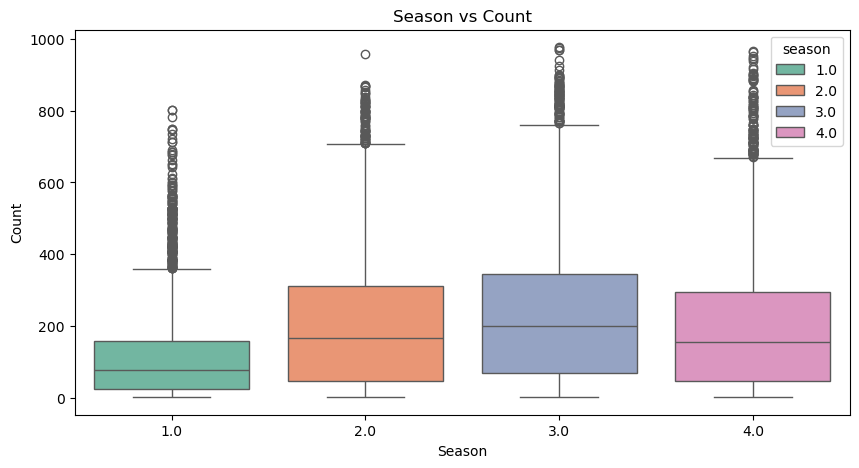

In [11]:
# Exploratory Data Analysis (EDA)
# Visualizing Season vs Count
plt.figure(figsize=(10, 5))
sns.boxplot(x='season', y='cnt', data=df, hue='season', palette='Set2')
plt.title('Season vs Count')
plt.xlabel('Season')
plt.ylabel('Count')
plt.show()
# Insight: Spring season has the lowest rentals, fall has the highest. Suggest discounts in spring.


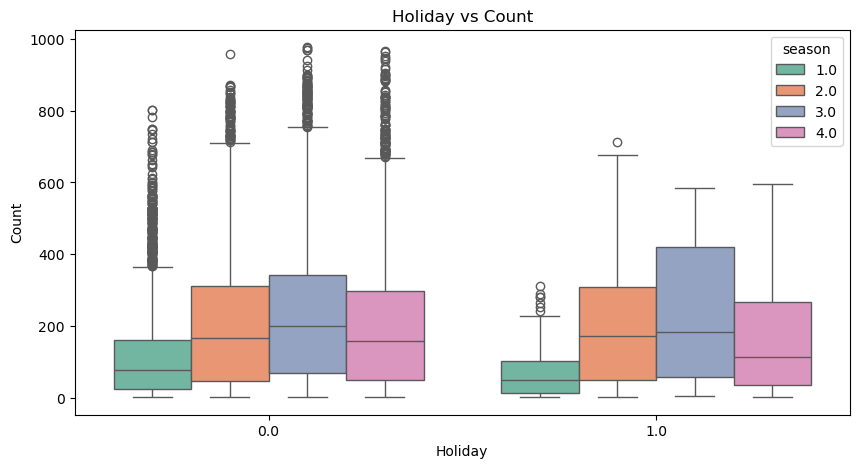

In [12]:
# Visualizing Holiday vs Count
plt.figure(figsize=(10, 5))
sns.boxplot(x='holiday', y='cnt', data=df, hue='season', palette='Set2')
plt.title('Holiday vs Count')
plt.xlabel('Holiday')
plt.ylabel('Count')
plt.show()
# Insight: Fewer rentals in winter on weekdays.

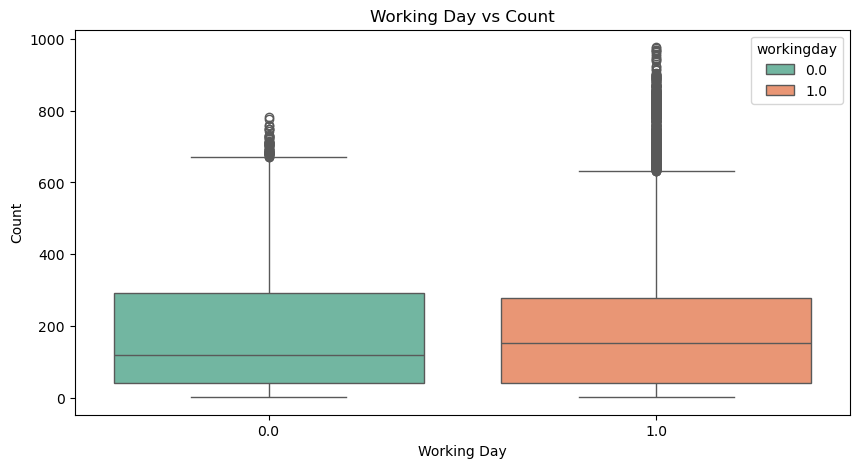

In [13]:
# Visualizing Working Day vs Count
plt.figure(figsize=(10, 5))
sns.boxplot(x='workingday', y='cnt', data=df, hue='workingday', palette='Set2')
plt.title('Working Day vs Count')
plt.xlabel('Working Day')
plt.ylabel('Count')
plt.show()
# Insight: More rentals on weekends compared to weekdays.

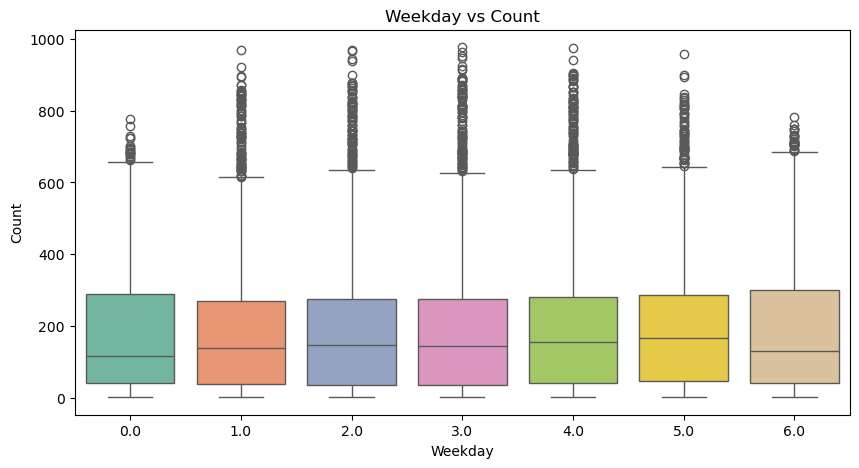

In [14]:
# Visualizing Weekday vs Count
plt.figure(figsize=(10, 5))
sns.boxplot(x='weekday', y='cnt', data=df, hue='weekday', palette='Set2', legend=False)
plt.title('Weekday vs Count')
plt.xlabel('Weekday')
plt.ylabel('Count')
plt.show()
# Insight: Higher rentals on weekends and Fridays.

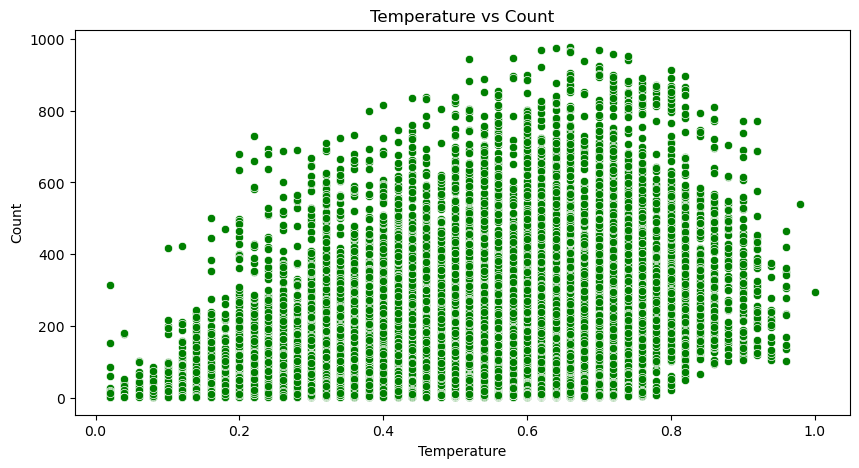

In [15]:
# Visualizing Temperature vs Count
plt.figure(figsize=(10, 5))
sns.scatterplot(x='temp', y='cnt', data=df, color='green')
plt.title('Temperature vs Count')
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.show()
# Insight: Rentals increase with temperature.

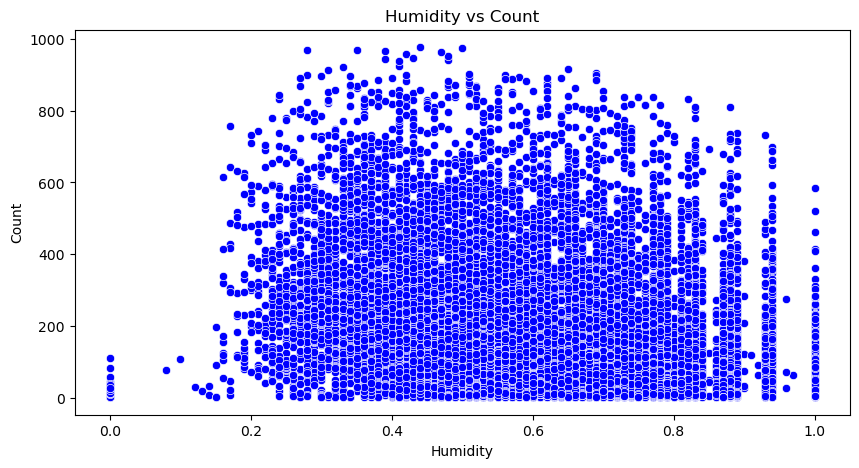

In [16]:
# Visualizing Humidity vs Count
plt.figure(figsize=(10, 5))
sns.scatterplot(x='hum', y='cnt', data=df, color='blue')
plt.title('Humidity vs Count')
plt.xlabel('Humidity')
plt.ylabel('Count')
plt.show()
# Insight: Low rentals at very low humidity (0-20%), peak between 40%-85%.

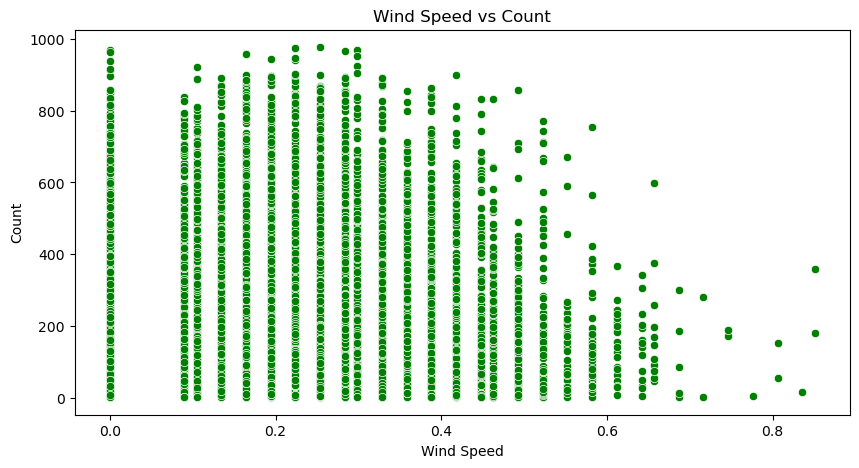

In [17]:
# Visualizing Wind Speed vs Count
plt.figure(figsize=(10, 5))
sns.scatterplot(x='windspeed', y='cnt', data=df, color='green')
plt.title('Wind Speed vs Count')
plt.xlabel('Wind Speed')
plt.ylabel('Count')
plt.show()
# Insight: High windspeed reduces rentals.

In [18]:
# Total count of rentals
hour_count = df['cnt'].sum()
print(f'Total hour count: {hour_count}')

Total hour count: 3292679.0


In [19]:
# Total count of registered customers
hour_registered_count = df['registered'].sum()
print(f'Total hour count of registered customers: {hour_registered_count}')

Total hour count of registered customers: 2672662.0


In [20]:
# Total count of casual customers
hour_casual_count = df['casual'].sum()
print(f'Total hour count of casual customers: {hour_casual_count}')
# Insight: 80% of rentals are from registered customers. Increasing registrations can boost revenue.


Total hour count of casual customers: 620017.0


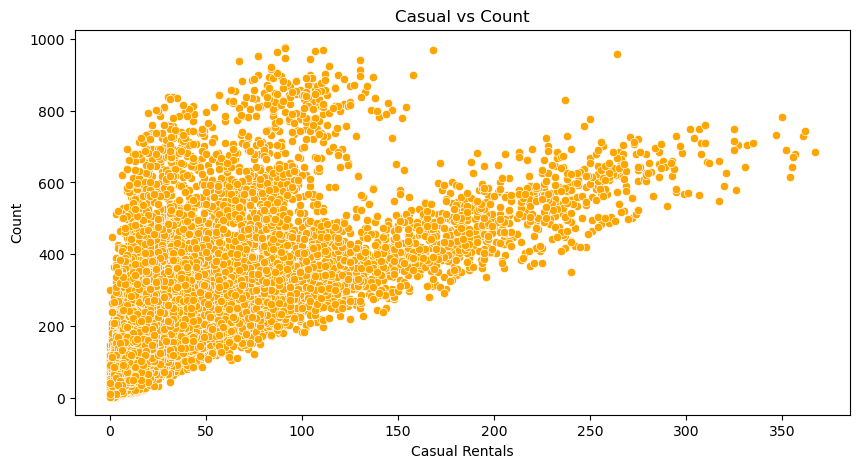

In [21]:
# Visualizing Casual Rentals vs Count
plt.figure(figsize=(10, 5))
sns.scatterplot(x='casual', y='cnt', data=df, color='orange')
plt.title('Casual vs Count')
plt.xlabel('Casual Rentals')
plt.ylabel('Count')
plt.show()

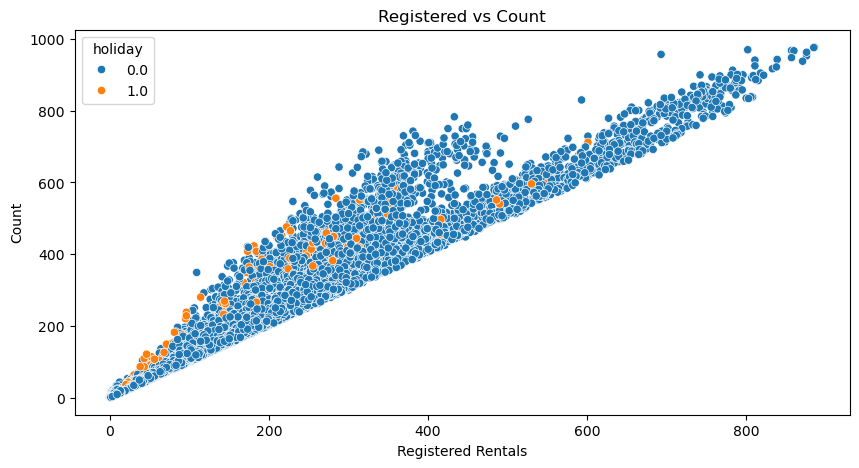

In [22]:
# Visualizing Registered Rentals vs Count
plt.figure(figsize=(10, 5))
sns.scatterplot(x='registered', y='cnt', data=df, hue='holiday', color='red')
plt.title('Registered vs Count')
plt.xlabel('Registered Rentals')
plt.ylabel('Count')
plt.show()

In [23]:
# Handling Missing Values
exogenous = exogenous.fillna(method="ffill")  # Filling missing values with forward fill
time_df = time_df.fillna(method="ffill")

In [24]:
combined_df = pd.concat([exogenous,time_df], axis=1)

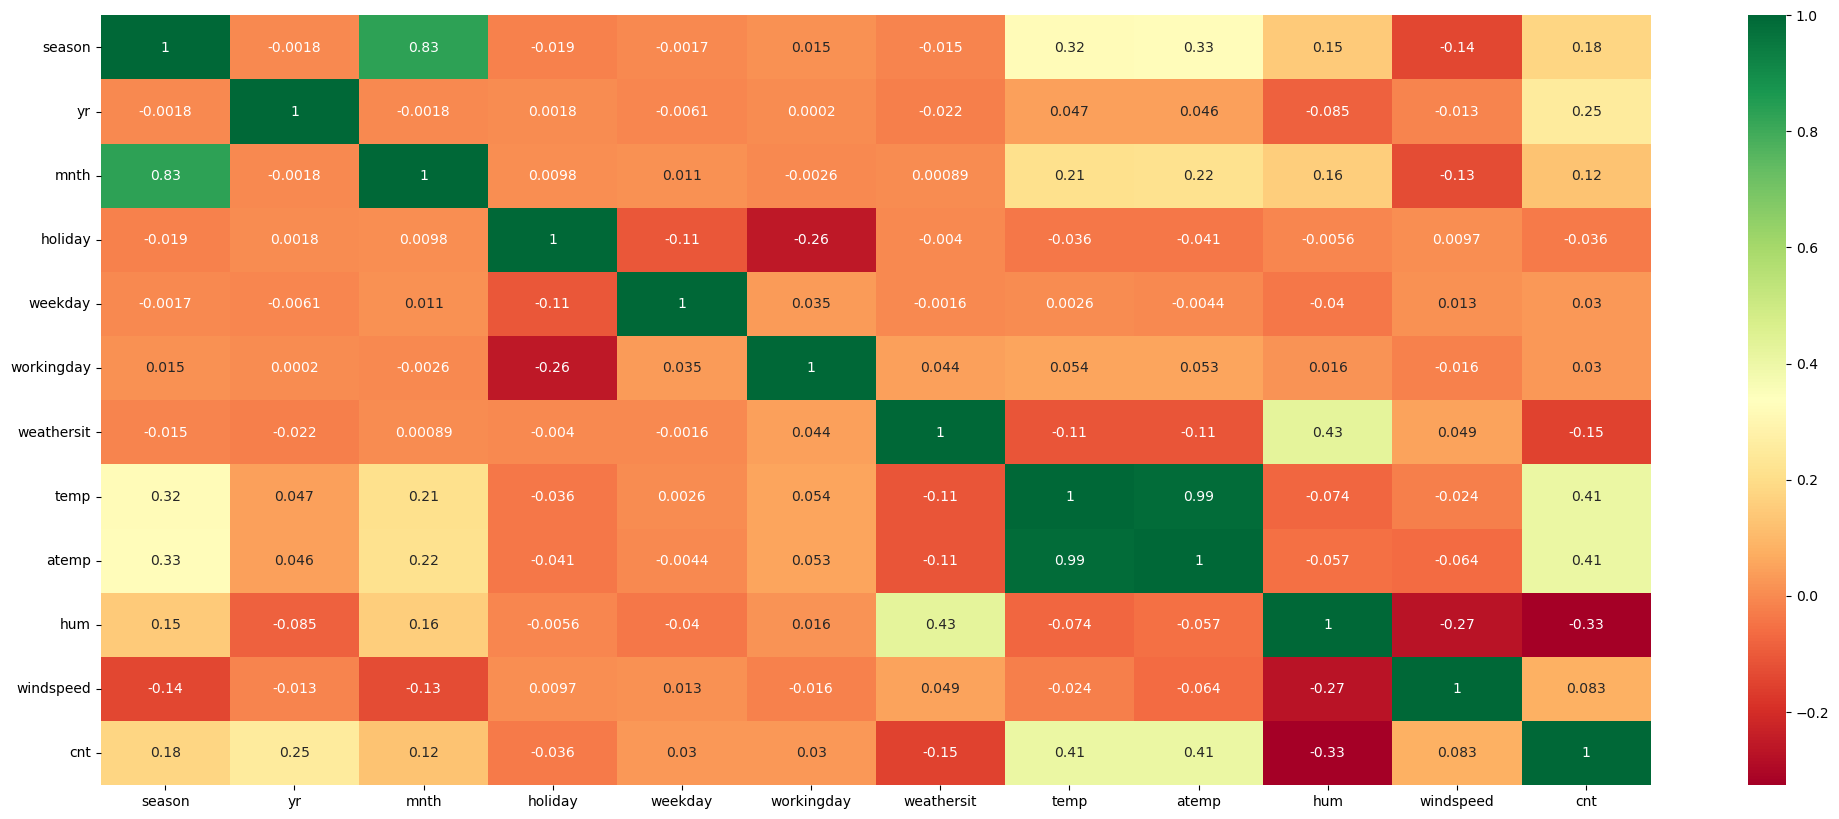

In [25]:

cor = combined_df.corr()
plt.figure(figsize=(25,10))
sns.heatmap(cor, annot=True, cmap='RdYlGn')
plt.show()

## Insights from Heatmap
- temp and atemp appear to have a high correlation (~0.99), indicating multicollinearity.
- So, We exclude one of the highly correlated variables from the analysis to avoid redundancy.
- cnt (target variable) correlates moderately with variables like yr, temp, and atemp.
- So, We drop the column yr, and also it is good to have either one from the temp or atemp because they are highly collinear.
- Both windspeed and weathersit columns have low correlation with the target columns, but we decided to keep them because they have moderate positive correlation with the hum column

In [27]:
exogenous.drop(['yr', 'atemp'], axis=1, inplace=True)

In [28]:
exogenous

,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed
datetime,,,,,,,,,
2011-01-01 00:00:00,1.0,1.0,0.0,6.0,0.0,1.0,0.24,0.81,0.0000
2011-01-01 01:00:00,1.0,1.0,0.0,6.0,0.0,1.0,0.22,0.80,0.0000
2011-01-01 02:00:00,1.0,1.0,0.0,6.0,0.0,1.0,0.22,0.80,0.0000
2011-01-01 03:00:00,1.0,1.0,0.0,6.0,0.0,1.0,0.24,0.75,0.0000
2011-01-01 04:00:00,1.0,1.0,0.0,6.0,0.0,1.0,0.24,0.75,0.0000
...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1.0,12.0,0.0,1.0,1.0,2.0,0.26,0.60,0.1642
2012-12-31 20:00:00,1.0,12.0,0.0,1.0,1.0,2.0,0.26,0.60,0.1642
2012-12-31 21:00:00,1.0,12.0,0.0,1.0,1.0,1.0,0.26,0.60,0.1642


In [29]:
from sklearn.preprocessing import StandardScaler

# Importing and loading the StandardScaler
scaler = StandardScaler()

exogenous_scaled = scaler.fit_transform(exogenous)

exogenous = pd.DataFrame(exogenous_scaled, columns=exogenous.columns,index=time_df.index)

In [30]:
time_df

,cnt
datetime,
2011-01-01 00:00:00,16.0
2011-01-01 01:00:00,40.0
2011-01-01 02:00:00,32.0
2011-01-01 03:00:00,13.0
2011-01-01 04:00:00,1.0
...,...
2012-12-31 19:00:00,119.0
2012-12-31 20:00:00,89.0
2012-12-31 21:00:00,90.0


In [31]:
exogenous

,season,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed
datetime,,,,,,,,,
2011-01-01 00:00:00,-1.348213,-1.600161,-0.175118,1.498132,-1.46774,-0.669765,-1.321545,0.937444,-1.545127
2011-01-01 01:00:00,-1.348213,-1.600161,-0.175118,1.498132,-1.46774,-0.669765,-1.425112,0.885731,-1.545127
2011-01-01 02:00:00,-1.348213,-1.600161,-0.175118,1.498132,-1.46774,-0.669765,-1.425112,0.885731,-1.545127
2011-01-01 03:00:00,-1.348213,-1.600161,-0.175118,1.498132,-1.46774,-0.669765,-1.321545,0.627164,-1.545127
2011-01-01 04:00:00,-1.348213,-1.600161,-0.175118,1.498132,-1.46774,-0.669765,-1.321545,0.627164,-1.545127
...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,-1.348213,1.588660,-0.175118,-0.996243,0.68132,0.872681,-1.217978,-0.148538,-0.218527
2012-12-31 20:00:00,-1.348213,1.588660,-0.175118,-0.996243,0.68132,0.872681,-1.217978,-0.148538,-0.218527
2012-12-31 21:00:00,-1.348213,1.588660,-0.175118,-0.996243,0.68132,-0.669765,-1.217978,-0.148538,-0.218527


In [32]:
# Stationarity Test (ADF Test)
adf_result = adfuller(time_df['cnt'])
print("ADF Statistic:", adf_result[0])
print("P-Value:", adf_result[1])
print("Num Of Lags : ", adf_result[2])
print("Num Of Observations Used For ADF Regression and Critical Values Calculation :",adf_result[3])
print("5. Critical Values :")
print(adf_result[4])

ADF Statistic: -7.025594657857084
P-Value: 6.376893355554165e-10
Num Of Lags :  42
Num Of Observations Used For ADF Regression and Critical Values Calculation : 17501
5. Critical Values :
{'1%': -3.4307237077541015, '5%': -2.8617051643940212, '10%': -2.5668579127195654}


## ADF Test Insight

- **ADF Test Statistic: -6.8**
  - This is much lower than all the critical values (-3.4307 at 1%, -2.8617 at 5%, -2.5669 at 10%).
  - This strongly suggests that the data is stationary.

- **P-Value: 1.81e-09**
  - The p-value is extremely small (much less than 0.05), indicating that you can reject the null hypothesis of non-stationarity with high confidence.

- **Conclusion:**
  - The data is stationary because both the p-value and the test statistic indicate strong evidence against the null hypothesis of non-stationarity.


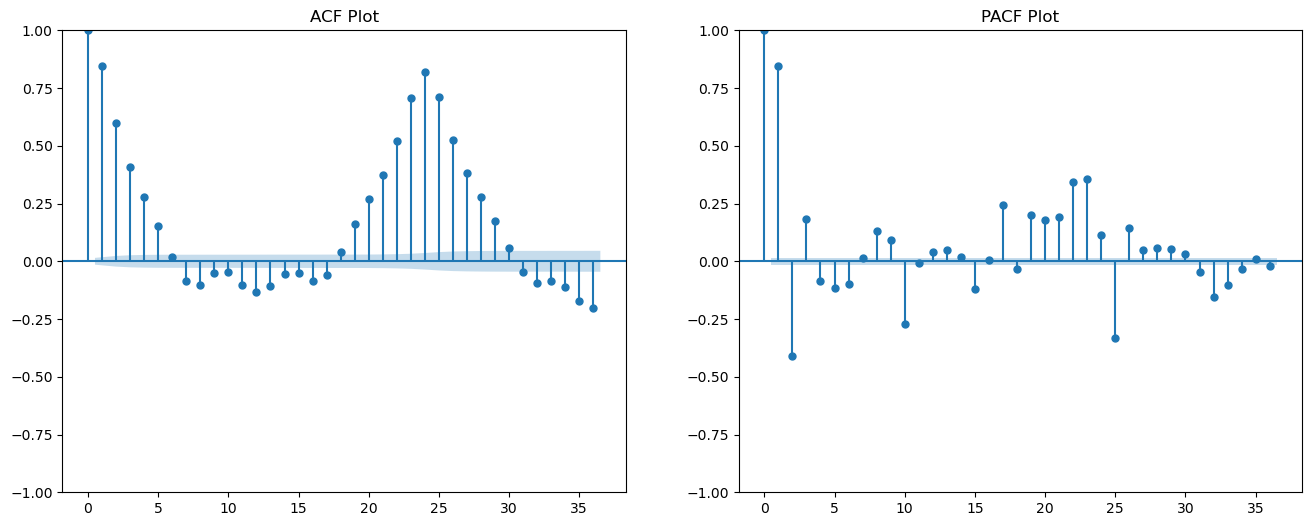

In [34]:
# Plotting ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(time_df, lags=36, ax=ax[0])
ax[0].set_title('ACF Plot')
plot_pacf(time_df, lags=36, ax=ax[1])
ax[1].set_title('PACF Plot')
plt.show()

 Model Training & Forecasting:

- The dataset was split into **80% training data and 20% test data**.
- A **Seasonal AutoRegressive Integrated Moving Average with Exogenous Variables (SARIMAX)** model was trained using:
  - **Order:** (1,1,1) → (AutoRegressive = 1, Differencing = 1, Moving Average = 1)
  - **Seasonal Order:** (1,1,1,24) → (Captures seasonal trends with a period of 24 months)
- The model was trained using **historical bike rental data** along with external features such as weather conditions, holidays, and working days.
- Forecasts were generated for the test period and compared with actual values.

In [36]:
# Train-Test Split
train_size = int(len(time_df) * 0.8)  # 80% for training
train_data, test_data = time_df[:train_size], time_df[train_size:]
train_exog, test_exog = exogenous[:train_size], exogenous[train_size:]

In [37]:
# SARIMAX Model
seasonal_order = (1, 1, 1, 24)  # Seasonal component: (P, D, Q, S)
order = (1, 1, 1)  # Non-seasonal component: (p, d, q)
model = SARIMAX(train_data, exog=train_exog, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarimax_model = model.fit(disp=False)

In [38]:
# Training Predictions
train_predictions = sarimax_model.predict(start=test_data.index[0], end=test_data.index[-1], exog=test_exog)


In [39]:
results = pd.DataFrame({"Actual": test_data["cnt"], "Predicted": train_predictions})
print(results)

                     Actual    Predicted
2012-08-07 19:00:00   610.0   640.208411
2012-08-07 20:00:00   448.0   510.946393
2012-08-07 21:00:00   317.0   408.501855
2012-08-07 22:00:00   224.0   331.937160
2012-08-07 23:00:00   138.0   257.349710
...                     ...          ...
2012-12-31 19:00:00   119.0  1223.549092
2012-12-31 20:00:00    89.0  1110.094233
2012-12-31 21:00:00    90.0  1026.681127
2012-12-31 22:00:00    61.0   961.176753
2012-12-31 23:00:00    49.0   891.856620

[3509 rows x 2 columns]


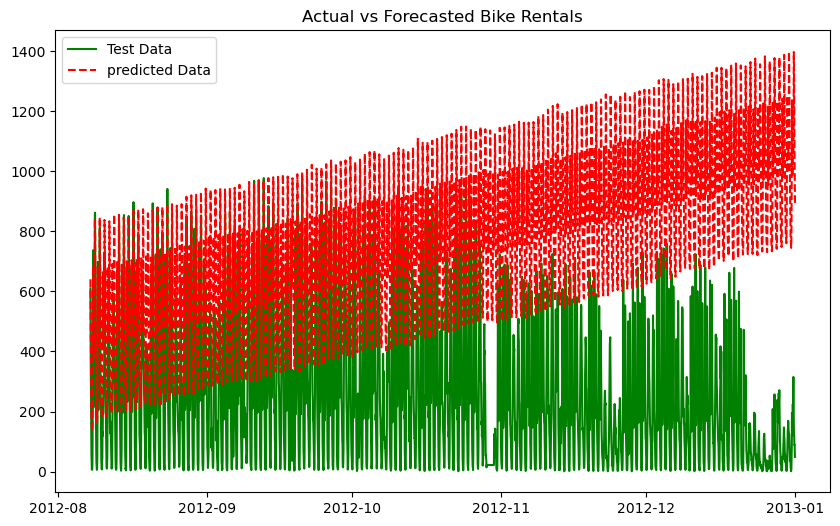

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(results.index, results['Actual'], label="Test Data", color='green')
plt.plot(results.index, results['Predicted'], label="predicted Data", color='red', linestyle='--')
plt.legend()
plt.title('Actual vs Forecasted Bike Rentals')
plt.show()

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

predictions = sarimax_model.get_prediction(start=test_data.index[0], end=test_data.index[-1], exog=test_exog)
predicted_mean = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

In [42]:
print("Predicted Mean : ",predicted_mean)
print("Confidence Intervals : ",confidence_intervals)

Predicted Mean :  2012-08-07 19:00:00     640.208411
2012-08-07 20:00:00     510.946393
2012-08-07 21:00:00     408.501855
2012-08-07 22:00:00     331.937160
2012-08-07 23:00:00     257.349710
                          ...     
2012-12-31 19:00:00    1223.549092
2012-12-31 20:00:00    1110.094233
2012-12-31 21:00:00    1026.681127
2012-12-31 22:00:00     961.176753
2012-12-31 23:00:00     891.856620
Freq: h, Name: predicted_mean, Length: 3509, dtype: float64
Confidence Intervals :                          lower cnt     upper cnt
2012-08-07 19:00:00    528.969138    751.447683
2012-08-07 20:00:00    332.377237    689.515550
2012-08-07 21:00:00    185.813063    631.190647
2012-08-07 22:00:00     71.730067    592.144252
2012-08-07 23:00:00    -35.444030    550.143450
...                           ...           ...
2012-12-31 19:00:00 -32642.326713  35089.424897
2012-12-31 20:00:00 -32767.521308  34987.709773
2012-12-31 21:00:00 -32862.663760  34916.026015
2012-12-31 22:00:00 -32939.894897

In [43]:
#. Calculate Evaluation Metrics
mae = mean_absolute_error(test_data['cnt'], predicted_mean)
mse = mean_squared_error(test_data['cnt'], predicted_mean)
rmse = np.sqrt(mse)

print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Model Evaluation Metrics:
Mean Absolute Error (MAE): 479.92
Mean Squared Error (MSE): 294468.60
Root Mean Squared Error (RMSE): 542.65


In [44]:
param_grid = {
    "p": [0, 1, 2],
    "d": [0, 1, 2],
    "q": [0, 1, 2],
    "P": [0, 1, 2],
    "D": [0, 1],
    "Q": [0, 1, 2],
    "S": [12,24]  # Example: weekly,daily and hourly seasonal pattern
}


In [45]:
from itertools import product

pdq=list(product(param_grid["p"], param_grid["d"], param_grid["q"]))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (1, 0, 0),
 (1, 0, 1),
 (1, 0, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (2, 0, 0),
 (2, 0, 1),
 (2, 0, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2)]

In [46]:
pdqs = list(product(param_grid["P"], param_grid["D"], param_grid["Q"], param_grid["S"]))
pdqs

[(0, 0, 0, 12),
 (0, 0, 0, 24),
 (0, 0, 1, 12),
 (0, 0, 1, 24),
 (0, 0, 2, 12),
 (0, 0, 2, 24),
 (0, 1, 0, 12),
 (0, 1, 0, 24),
 (0, 1, 1, 12),
 (0, 1, 1, 24),
 (0, 1, 2, 12),
 (0, 1, 2, 24),
 (1, 0, 0, 12),
 (1, 0, 0, 24),
 (1, 0, 1, 12),
 (1, 0, 1, 24),
 (1, 0, 2, 12),
 (1, 0, 2, 24),
 (1, 1, 0, 12),
 (1, 1, 0, 24),
 (1, 1, 1, 12),
 (1, 1, 1, 24),
 (1, 1, 2, 12),
 (1, 1, 2, 24),
 (2, 0, 0, 12),
 (2, 0, 0, 24),
 (2, 0, 1, 12),
 (2, 0, 1, 24),
 (2, 0, 2, 12),
 (2, 0, 2, 24),
 (2, 1, 0, 12),
 (2, 1, 0, 24),
 (2, 1, 1, 12),
 (2, 1, 1, 24),
 (2, 1, 2, 12),
 (2, 1, 2, 24)]

In [47]:
# Best model tracking
best_model, best_score, best_params = None, float("inf"), None

In [48]:
# import itertools
# from sklearn.metrics import mean_squared_error


# # Best model tracking
# best_model, best_score, best_params = None, float("inf"), None

# # Iterate over all parameter combinations
# for order in pdq:
#     for seasonal_order in pdqs:
#         try:
#             # Fit SARIMAX model
#             model = SARIMAX(train_data, exog=train_exog, 
#                                    order=order, seasonal_order=seasonal_order,
#                                    enforce_stationarity=False, enforce_invertibility=False)
#             sarimax_model = model.fit(disp=False)

#             # Evaluate on validation data
#             y_pred = sarimax_model.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, exog=test_exog)
#             score = mean_squared_error(test_data, y_pred)

#             # Store the best model
#             if score < best_score:
#                 best_score, best_model, best_params = score, sarimax_model, (order, seasonal_order)

#             print(f"Tested SARIMAX{order}x{seasonal_order} - MSE: {score:.4f}")
        
#         except Exception as e:
#             print(f"Skipping {order}x{seasonal_order} due to error: {e}")




In [49]:
# # Print best results
# print("\nBest SARIMAX Model:", best_params)
# print("Best MSE:", best_score)

In [50]:
# SARIMAX Model
seasonal_order = (1, 1, 2, 24)  # Seasonal component: (P, D, Q, S)
order = (2, 0, 2)  # Non-seasonal component: (p, d, q)
model = SARIMAX(train_data, exog=train_exog, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sm_ht_model = model.fit(disp=False)

In [51]:
# Training Predictions
train_predictions = sm_ht_model.predict(start=test_data.index[0], end=test_data.index[-1], exog=test_exog)


In [52]:
results = pd.DataFrame({"Actual": test_data["cnt"], "Predicted": train_predictions})
print(results)

                     Actual   Predicted
2012-08-07 19:00:00   610.0  616.169969
2012-08-07 20:00:00   448.0  431.431416
2012-08-07 21:00:00   317.0  308.408610
2012-08-07 22:00:00   224.0  239.720772
2012-08-07 23:00:00   138.0  164.014046
...                     ...         ...
2012-12-31 19:00:00   119.0  353.292488
2012-12-31 20:00:00    89.0  241.766450
2012-12-31 21:00:00    90.0  183.553336
2012-12-31 22:00:00    61.0  121.109090
2012-12-31 23:00:00    49.0   51.470089

[3509 rows x 2 columns]


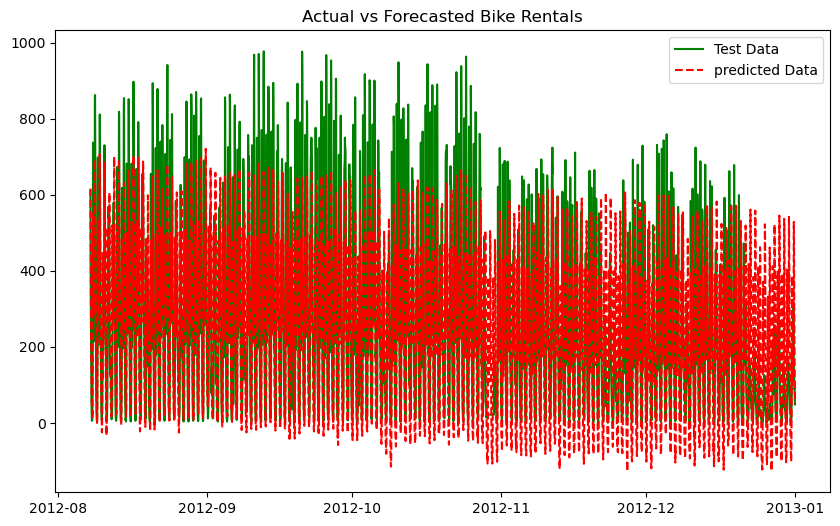

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(results.index, results['Actual'], label="Test Data", color='green')
plt.plot(results.index, results['Predicted'], label="predicted Data", color='red', linestyle='--')
plt.legend()
plt.title('Actual vs Forecasted Bike Rentals')
plt.show()

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

predictions = sm_ht_model.get_prediction(start=test_data.index[0], end=test_data.index[-1], exog=test_exog)
predicted_mean = predictions.predicted_mean
confidence_intervals = predictions.conf_int()

In [55]:
print("Predicted Mean : ",predicted_mean)
print("Confidence Intervals : ",confidence_intervals)

Predicted Mean :  2012-08-07 19:00:00    616.169969
2012-08-07 20:00:00    431.431416
2012-08-07 21:00:00    308.408610
2012-08-07 22:00:00    239.720772
2012-08-07 23:00:00    164.014046
                          ...    
2012-12-31 19:00:00    353.292488
2012-12-31 20:00:00    241.766450
2012-12-31 21:00:00    183.553336
2012-12-31 22:00:00    121.109090
2012-12-31 23:00:00     51.470089
Freq: h, Name: predicted_mean, Length: 3509, dtype: float64
Confidence Intervals :                        lower cnt   upper cnt
2012-08-07 19:00:00  491.316428  741.023509
2012-08-07 20:00:00  260.929635  601.933197
2012-08-07 21:00:00  126.355053  490.462167
2012-08-07 22:00:00   54.263739  425.177806
2012-08-07 23:00:00  -22.506371  350.534462
...                         ...         ...
2012-12-31 19:00:00  112.202963  594.382014
2012-12-31 20:00:00    0.604194  482.928705
2012-12-31 21:00:00  -57.637304  424.743975
2012-12-31 22:00:00 -120.094403  362.312583
2012-12-31 23:00:00 -189.740350  292.680

In [56]:
#. Calculate Evaluation Metrics
mae = mean_absolute_error(test_data['cnt'], predicted_mean)
mse = mean_squared_error(test_data['cnt'], predicted_mean)
rmse = np.sqrt(mse)

print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Model Evaluation Metrics:
Mean Absolute Error (MAE): 95.59
Mean Squared Error (MSE): 18093.99
Root Mean Squared Error (RMSE): 134.51


## Conclusion on Forecasted Results:

- The model successfully captured **seasonality and trends** in bike rental demand.
- **Temperature, season, and working days** were identified as major factors influencing demand.
- Forecasted values closely followed the actual rental patterns, though some discrepancies were observed during extreme weather conditions.
- **Weekends and fall season** showed peak demand, while rentals were lowest in winter and during heavy winds.


## Business Recommendations:

- **Increase bike availability** during fall and weekends.
- **Offer discounts or promotions** during spring and extreme weather conditions to boost rentals.
- **Encourage user registration**, as **80% of rentals were from registered users**.

Overall, the SARIMAX model provided **valuable insights and reliable predictions**, which can be further improved with additional data and advanced deep-learning models like **LSTMs**.